### Task description
Visualize KL-divergence (for 3 variants: KL(p1,p2), KL(p2,p1) and 0.5 KL(p1,p2) + 0.5 KL(p2,p1)) and JS distance between true data distribution and GAN distribution. Visulize dependence of these KL-divergences on the numer of optimization iterations. Dataset: synthetic.

### Method

Let's recall the definitions of forward, reverse KL divergences and Jensen-Shannon's distance:

* Forward KL
$$KL(\pi || p) = \int \pi (x) \log \frac{\pi(x)}{p(x)} d x $$

* Reverse KL
$$KL(p || \pi) = \int p (x) \log \frac{p(x)}{\pi(x)} d x $$

* JS distance
$$JSD(p || \pi) = \frac{1}{2} (KL(\pi ||\frac{p+\pi}{2}) + KL(p ||\frac{p+\pi}{2})).$$

Here $\pi (x)$ defined as true data distribution and $p(x)$ as GAN's distribution.

In this lab bimodal one dimensional gaussian mixture was used as target dataset and GAN was trained with respect to it.
To obtain GAN's pdf at each training step, samples were estimated using two techniques: kernel densety estimation and gaussian mixture model.
Afterwards, forward, reverse KL divergences and Jensen-Shannon's distance were calculated. Each optimization iteration with distributions and values of KL divergences and Jensen-Shannon's distance was visualized.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.distributions as TD

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import entropy

from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

In [ ]:
# implement generator model
class Generator(nn.Module):
  def __init__(self, n_channels=64):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(1, n_channels),
            nn.ReLU(),
            nn.Linear(n_channels, n_channels),
            nn.ReLU(),
            nn.Linear(n_channels, n_channels),
            nn.ReLU(),
            nn.Linear(n_channels, 1)
        )

  def forward(self, x):
        x = self.net(x)
        return x

In [ ]:
# implement discriminator model
class Discriminator(nn.Module):
  def __init__(self, n_channels=64):
      super().__init__()

      self.net = nn.Sequential(
          nn.Linear(1, n_channels),
          nn.ReLU(),
          nn.Linear(n_channels, n_channels),
          nn.ReLU(),
          nn.Linear(n_channels, n_channels),
          nn.ReLU(),
          nn.Linear(n_channels, 1),
          nn.Sigmoid()
      )

  def forward(self, x):
        x = self.net(x)
        return x

In [ ]:
class VanillaGAN():
    def __init__(self, G, D, noise_fn, data_fn,
                 batch_size=32, lr_D=1e-3, lr_G=2e-4):
        self.G = G
        self.D = D
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size

        self.criterion = nn.BCELoss()
        self.optim_D = optim.Adam(D.parameters(),
                                  lr=lr_D, betas=(0.5, 0.999))
        self.optim_G = optim.Adam(G.parameters(),
                                  lr=lr_G, betas=(0.5, 0.999))

        self.target_ones = torch.ones((batch_size, 1))
        self.target_zeros = torch.zeros((batch_size, 1))

    # generate samples
    def generate_samples(self, latent_vec=None, num=None):
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
          samples = self.G(latent_vec)

        return samples

    # generator train step
    def train_step_G(self):
        self.G.zero_grad()
        latent_vec = self.noise_fn(self.batch_size)
        generated = self.G(latent_vec)
        classififcations = self.D(generated)
        loss = self.criterion(classififcations, self.target_ones)
        loss.backward()
        self.optim_G.step()
        return loss.item()

    # discriminator train step
    def train_step_D(self):
        self.D.zero_grad()
        # real samples
        real_samples = self.data_fn(self.batch_size)
        pred_real = self.D(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)
        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        fake_samples = self.G(latent_vec)
        pred_fake = self.D(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_D.step()

        return loss_real.item(), loss_fake.item()

    def train_step(self):
        loss_D = self.train_step_D()
        loss_G = self.train_step_G()
        return loss_G, loss_D

In [ ]:
# define target distribution and noise function (latent space)
pi = torch.tensor([0.7, 0.3])
mu = torch.tensor([-3., 3.])
scale = torch.tensor([1., 1.])

mixture_gaussian = TD.MixtureSameFamily(TD.Categorical(pi), TD.Normal(mu, scale))

def data_fn(x):
    return mixture_gaussian.sample((x, 1))

def data_pdf(x):
    return mixture_gaussian.log_prob(torch.tensor(x)).exp().numpy()

def noise_fn(x):
  return TD.Normal(torch.tensor(0.0), torch.tensor(1.0)).sample((x, 1))

# another noise function
# def noise_fn(x):
#   return TD.uniform.Uniform(torch.tensor(0.0), torch.tensor(1.0)).sample((x, 1))

In [ ]:
# define GAN
G = Generator()
D = Discriminator()

gan = VanillaGAN(G, D, noise_fn, data_fn)
loss_g, loss_d_real, loss_d_fake = [], [], []

In [ ]:
# main function where GANs pdf is estimated and divergences are computed
def visualize_results(gan, data_pdf):
    size = 500
    x = np.linspace(-6,6,100)
    bins = np.linspace(-6,6,60)
    real_data = gan.data_fn(size)
    noise = gan.noise_fn(size)
    sampled_data = gan.generate_samples(noise)
    target_pdf = data_pdf(x)
    gan_sampled_data = sampled_data.numpy()

    # estimating GANs pdf using Gaussian mixture model
    gm = GaussianMixture(n_components=2, random_state=0).fit(gan_sampled_data)
    # get weights
    w1, w2 = gm.weights_[0], gm.weights_[1]
    # get means
    m1, m2 = gm.means_[0].item(), gm.means_[1].item()
    # get stds
    s1, s2 =  gm.covariances_[0].item(),  gm.covariances_[1].item()
    gan_gmm_pdf = w1 * stats.norm.pdf(x, m1, s1) + w2 * stats.norm.pdf(x, m2, s2)

    # divergences computation
    fkl_gmm = entropy(pk=target_pdf, qk=gan_gmm_pdf, axis=0)
    rkl_gmm = entropy(pk=gan_gmm_pdf, qk=target_pdf, axis=0)
    mean_distrib_gmm = (gan_gmm_pdf + target_pdf) / 2
    jsd_gmm = 1 / 2 * (entropy(pk=target_pdf, qk=mean_distrib_gmm, axis=0) + entropy(pk=gan_gmm_pdf, qk=mean_distrib_gmm, axis=0))

    print("GMM | ", "Forward KL:" "%.3f" %fkl_gmm, " |  Reverse KL:" "%.3f" %rkl_gmm, " |  JSD:" "%.3f" %jsd_gmm)
    plt.plot(x, gan_gmm_pdf, 'r', label='GAN pdf with GMM')

    # estimating GANs pdf using kernel density estimation
    kde = KernelDensity(kernel='gaussian').fit(gan_sampled_data)
    gan_kde_pdf = np.exp(kde.score_samples(x.reshape(-1, 1)))

    # divergences computation
    fkl_kde = entropy(pk=target_pdf, qk=gan_kde_pdf, axis=0)
    rkl_kde = entropy(pk=gan_kde_pdf, qk=target_pdf, axis=0)
    mean_distrib_kde = (gan_kde_pdf + target_pdf) / 2
    jsd_kde = 1 / 2 * (entropy(pk=target_pdf, qk=mean_distrib_kde, axis=0) + entropy(pk=gan_kde_pdf, qk=mean_distrib_kde, axis=0))

    print("KDE | ", "Forward KL:" "%.3f" %fkl_kde, " |  Reverse KL:" "%.3f" %rkl_kde, " |  JSD:" "%.3f" %jsd_kde)
    plt.plot(x, gan_kde_pdf, 'brown', label='GAN pdf with KDE')

    # real data samples and generated
    plt.hist(real_data.numpy(), label='Real data', alpha=0.5, density=True, color='g', bins=bins)
    plt.hist(sampled_data.numpy(), label='GAN samples', alpha=0.5, density=True, color='r', bins=bins)
    plt.plot(x, data_pdf(x), 'g', label='Real pdf')

    plt.legend(loc='upper right')
    plt.show()

In [ ]:
# visualize_results(gan, data_pdf=data_pdf)

Epoch 1/25: G=1.963, Dr=0.198, Df=0.344
GMM |  Forward KL:1.870  |  Reverse KL:1.557  |  JSD:0.298
KDE |  Forward KL:0.862  |  Reverse KL:1.219  |  JSD:0.211


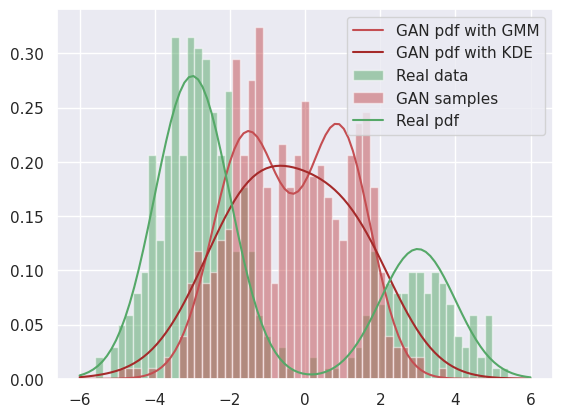

Epoch 2/25: G=1.281, Dr=0.610, Df=0.592
GMM |  Forward KL:0.340  |  Reverse KL:0.536  |  JSD:0.095
KDE |  Forward KL:0.217  |  Reverse KL:0.340  |  JSD:0.062


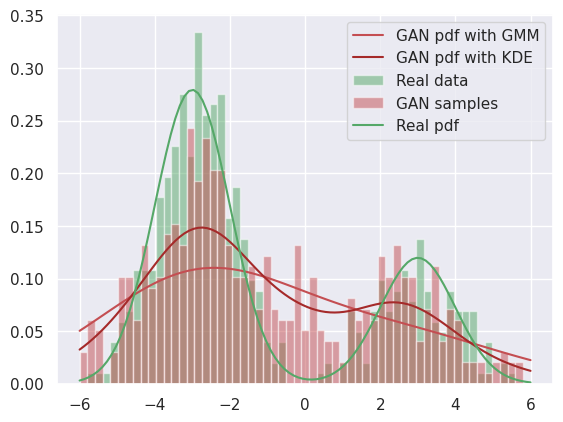

Epoch 3/25: G=0.818, Dr=0.672, Df=0.656
GMM |  Forward KL:0.316  |  Reverse KL:0.494  |  JSD:0.088
KDE |  Forward KL:0.197  |  Reverse KL:0.297  |  JSD:0.055


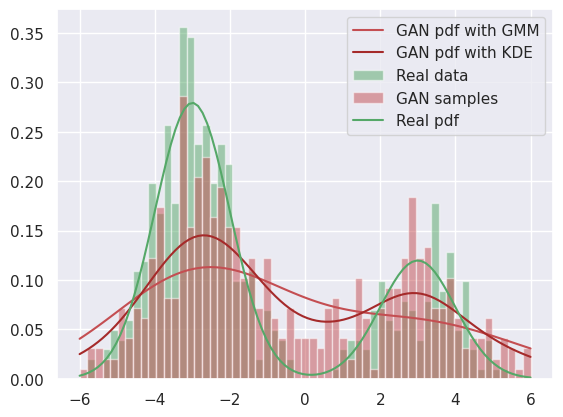

Epoch 4/25: G=0.785, Dr=0.657, Df=0.668
GMM |  Forward KL:0.193  |  Reverse KL:0.290  |  JSD:0.054
KDE |  Forward KL:0.151  |  Reverse KL:0.224  |  JSD:0.042


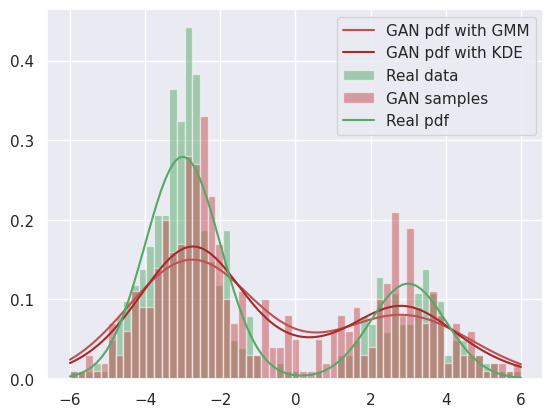

Epoch 5/25: G=0.780, Dr=0.670, Df=0.679
GMM |  Forward KL:0.091  |  Reverse KL:0.135  |  JSD:0.026
KDE |  Forward KL:0.132  |  Reverse KL:0.199  |  JSD:0.037


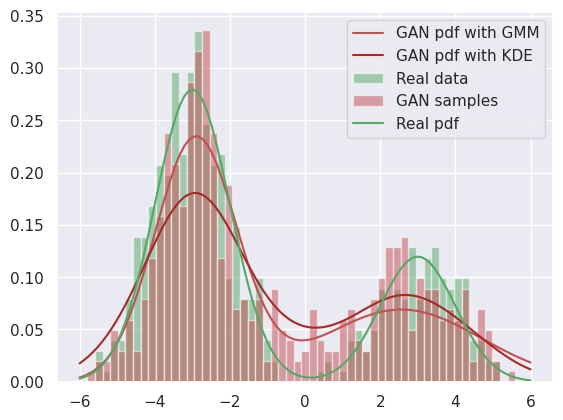

Epoch 6/25: G=0.749, Dr=0.686, Df=0.682
GMM |  Forward KL:0.094  |  Reverse KL:0.143  |  JSD:0.027
KDE |  Forward KL:0.126  |  Reverse KL:0.189  |  JSD:0.036


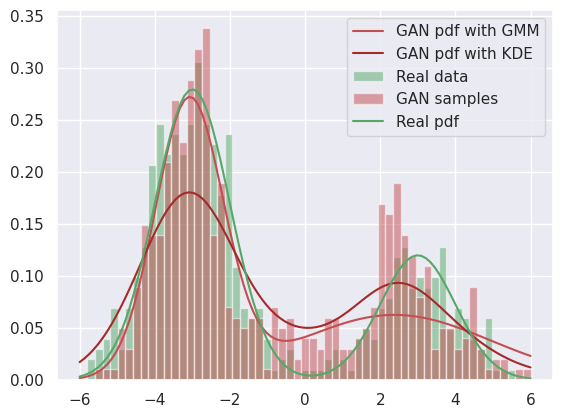

Epoch 7/25: G=0.742, Dr=0.688, Df=0.681
GMM |  Forward KL:0.103  |  Reverse KL:0.136  |  JSD:0.028
KDE |  Forward KL:0.110  |  Reverse KL:0.162  |  JSD:0.031


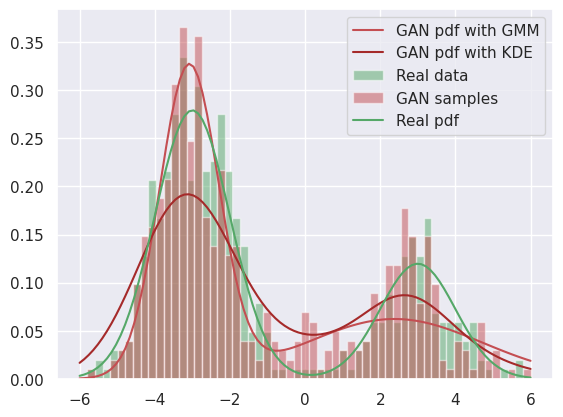

Epoch 8/25: G=0.719, Dr=0.679, Df=0.694
GMM |  Forward KL:0.162  |  Reverse KL:0.180  |  JSD:0.039
KDE |  Forward KL:0.094  |  Reverse KL:0.135  |  JSD:0.026


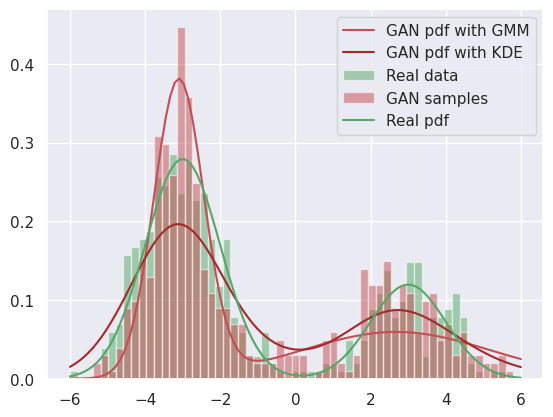

Epoch 9/25: G=0.732, Dr=0.687, Df=0.689
GMM |  Forward KL:0.438  |  Reverse KL:0.346  |  JSD:0.085
KDE |  Forward KL:0.080  |  Reverse KL:0.120  |  JSD:0.023


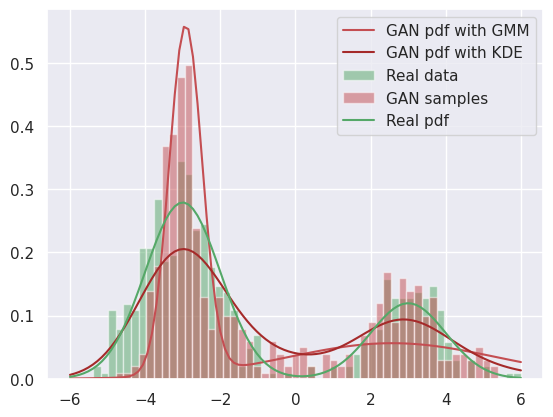

Epoch 10/25: G=0.715, Dr=0.687, Df=0.690
GMM |  Forward KL:0.264  |  Reverse KL:0.230  |  JSD:0.057
KDE |  Forward KL:0.101  |  Reverse KL:0.137  |  JSD:0.028


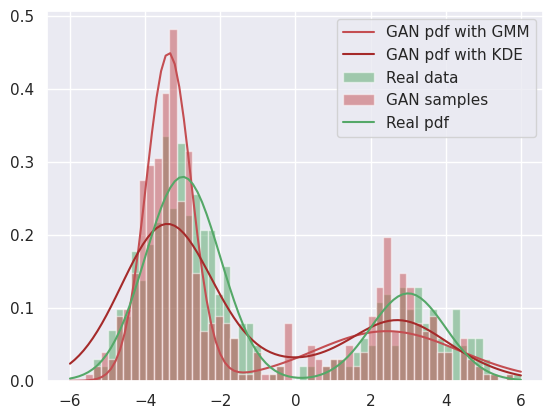

Epoch 11/25: G=0.710, Dr=0.685, Df=0.692
GMM |  Forward KL:0.676  |  Reverse KL:0.338  |  JSD:0.091
KDE |  Forward KL:0.059  |  Reverse KL:0.082  |  JSD:0.017


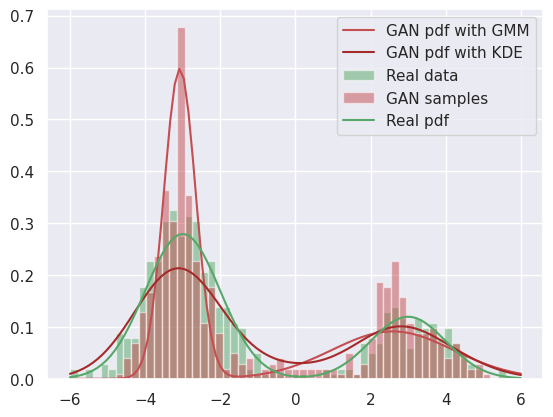

Epoch 12/25: G=0.706, Dr=0.691, Df=0.691
GMM |  Forward KL:0.444  |  Reverse KL:0.234  |  JSD:0.063
KDE |  Forward KL:0.068  |  Reverse KL:0.099  |  JSD:0.019


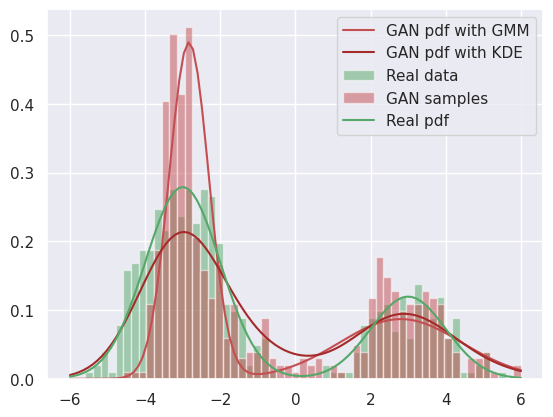

Epoch 13/25: G=0.704, Dr=0.692, Df=0.693
GMM |  Forward KL:0.731  |  Reverse KL:0.484  |  JSD:0.125
KDE |  Forward KL:0.057  |  Reverse KL:0.074  |  JSD:0.016


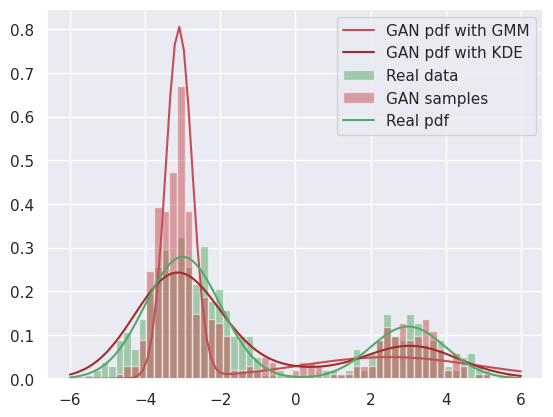

Epoch 14/25: G=0.702, Dr=0.688, Df=0.691
GMM |  Forward KL:0.708  |  Reverse KL:0.554  |  JSD:0.136
KDE |  Forward KL:0.068  |  Reverse KL:0.100  |  JSD:0.019


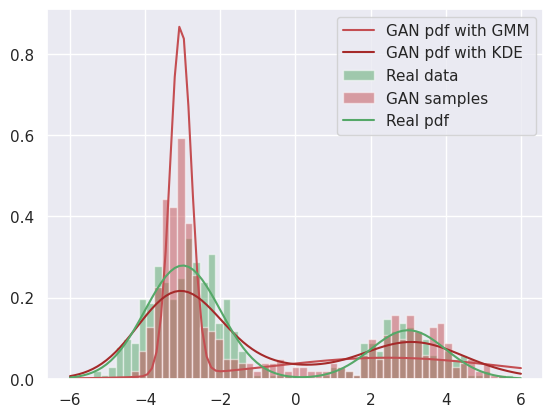

Epoch 15/25: G=0.702, Dr=0.689, Df=0.693
GMM |  Forward KL:0.995  |  Reverse KL:0.497  |  JSD:0.131
KDE |  Forward KL:0.053  |  Reverse KL:0.077  |  JSD:0.015


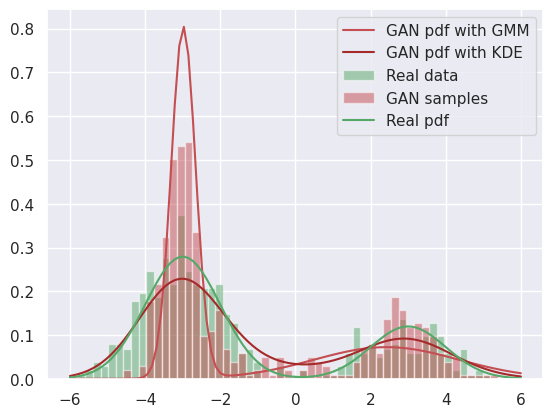

Epoch 16/25: G=0.701, Dr=0.687, Df=0.691
GMM |  Forward KL:0.294  |  Reverse KL:0.185  |  JSD:0.049
KDE |  Forward KL:0.070  |  Reverse KL:0.100  |  JSD:0.020


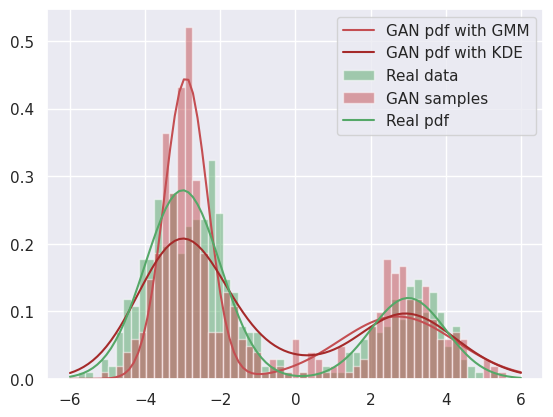

Epoch 17/25: G=0.703, Dr=0.687, Df=0.690
GMM |  Forward KL:0.053  |  Reverse KL:0.046  |  JSD:0.012
KDE |  Forward KL:0.095  |  Reverse KL:0.135  |  JSD:0.027


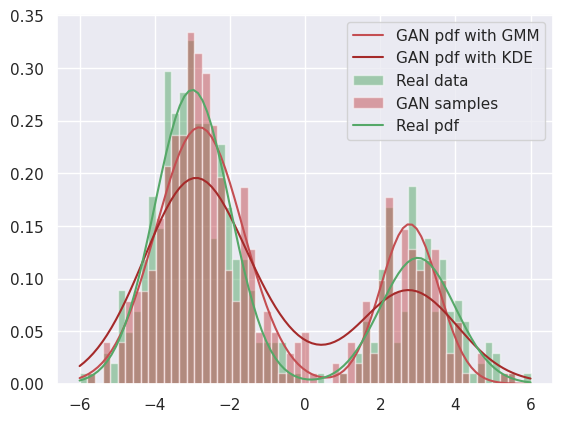

Epoch 18/25: G=0.708, Dr=0.691, Df=0.690
GMM |  Forward KL:0.034  |  Reverse KL:0.043  |  JSD:0.009
KDE |  Forward KL:0.101  |  Reverse KL:0.142  |  JSD:0.028


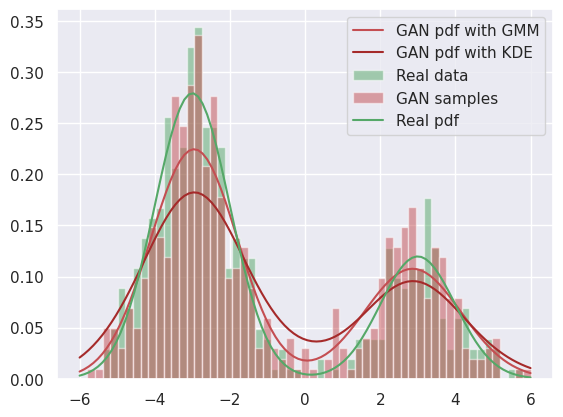

Epoch 19/25: G=0.703, Dr=0.690, Df=0.692
GMM |  Forward KL:0.013  |  Reverse KL:0.015  |  JSD:0.003
KDE |  Forward KL:0.085  |  Reverse KL:0.116  |  JSD:0.024


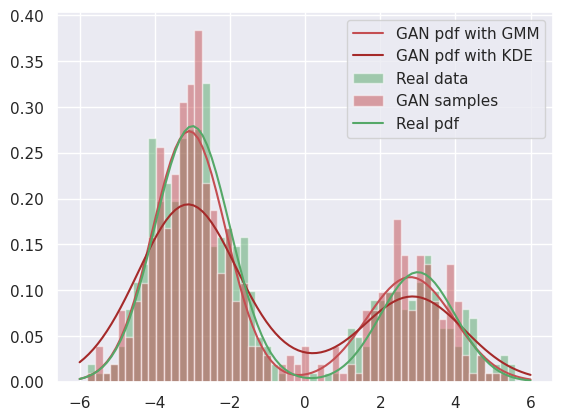

Epoch 20/25: G=0.701, Dr=0.691, Df=0.693
GMM |  Forward KL:0.087  |  Reverse KL:0.116  |  JSD:0.024
KDE |  Forward KL:0.112  |  Reverse KL:0.159  |  JSD:0.031


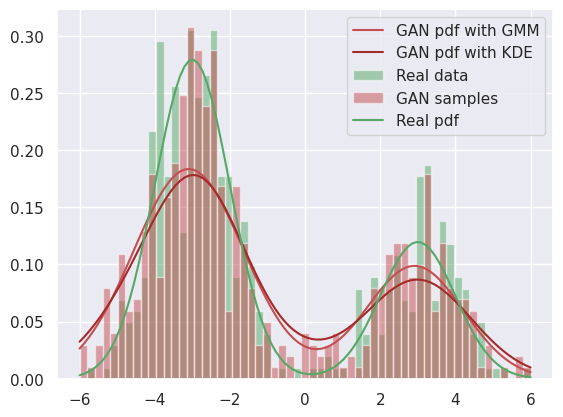

Epoch 21/25: G=0.700, Dr=0.690, Df=0.692
GMM |  Forward KL:0.069  |  Reverse KL:0.062  |  JSD:0.016
KDE |  Forward KL:0.097  |  Reverse KL:0.132  |  JSD:0.027


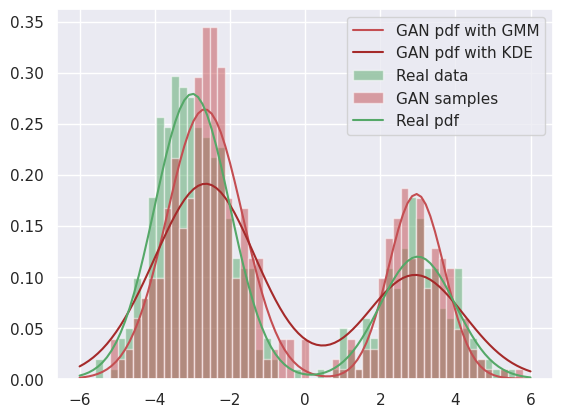

Epoch 22/25: G=0.702, Dr=0.690, Df=0.693
GMM |  Forward KL:0.049  |  Reverse KL:0.039  |  JSD:0.010
KDE |  Forward KL:0.089  |  Reverse KL:0.123  |  JSD:0.025


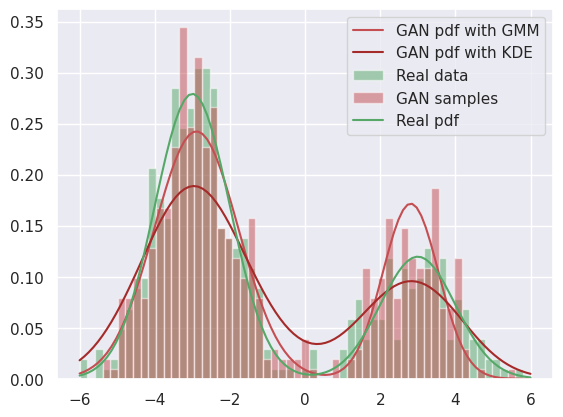

Epoch 23/25: G=0.692, Dr=0.687, Df=0.696
GMM |  Forward KL:0.047  |  Reverse KL:0.059  |  JSD:0.013
KDE |  Forward KL:0.104  |  Reverse KL:0.145  |  JSD:0.029


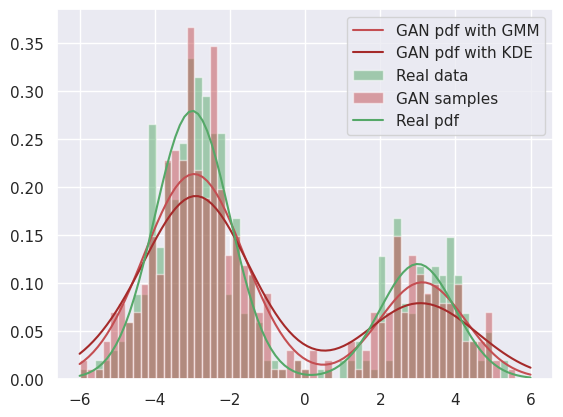

Epoch 24/25: G=0.700, Dr=0.694, Df=0.689
GMM |  Forward KL:0.013  |  Reverse KL:0.014  |  JSD:0.003
KDE |  Forward KL:0.091  |  Reverse KL:0.126  |  JSD:0.025


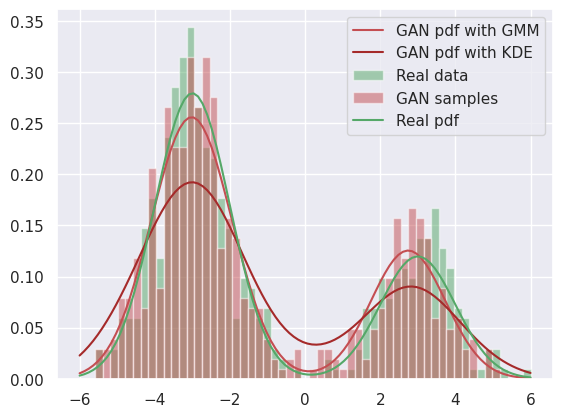

Epoch 25/25: G=0.699, Dr=0.690, Df=0.694
GMM |  Forward KL:0.008  |  Reverse KL:0.008  |  JSD:0.002
KDE |  Forward KL:0.087  |  Reverse KL:0.117  |  JSD:0.024


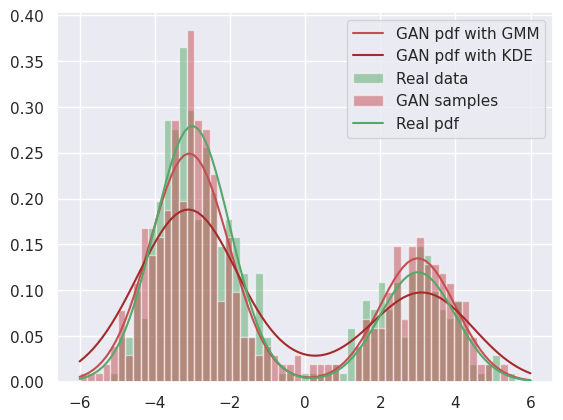

In [ ]:
# training loop and visualization
epochs = 25
batches = 100
for epoch in range(epochs):
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs}:"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_results(gan, data_pdf=data_pdf)